In [247]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set(style='white', palette='muted', color_codes=True)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import plotly.express as px 


In [248]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression,LinearRegression 
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, confusion_matrix, silhouette_score 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.cluster import KMeans 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor 
from sklearn.pipeline import Pipeline

In [249]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [250]:
data.duplicated().sum()
data.drop_duplicates(inplace=True, ignore_index=False, keep='first', subset=None)
data.duplicated().sum()

0

In [251]:
mis_val = data.isna().sum() * 100 / len(data)
mis_val.sort_values(ascending=False)
mis_val

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [252]:
orig_sex = data.sex 

le = LabelEncoder()

le_sex = le.fit_transform(data.sex)

data.sex = le_sex
orig_dic_sex = np.unique(orig_sex)
le_dic_sex = np.unique(le_sex)

sex_dic = dict(zip(orig_dic_sex,le_dic_sex))
sex_dic

{'female': 0, 'male': 1}

<AxesSubplot:title={'center':'Correlation Matrix'}>

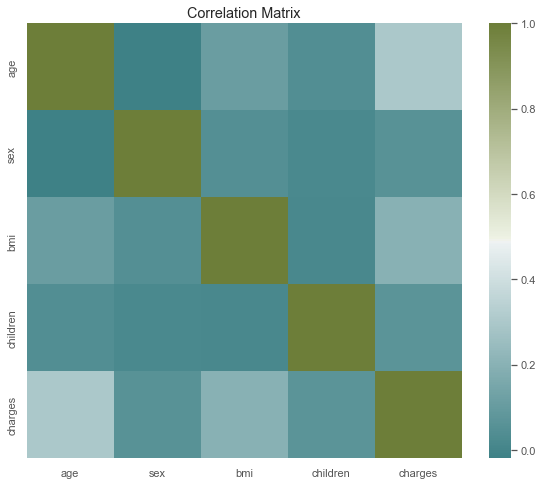

In [253]:
f,ax = plt.subplots(figsize=(10,8))

data_corr = data.corr()

ax.set_title('Correlation Matrix')
sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_), cmap=sns.diverging_palette(200,100, as_cmap=True), ax=ax, square=True)

In [254]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   int32  
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int32(1), int64(2), object(2)
memory usage: 78.3+ KB


In [255]:
data.smoker = le.fit_transform(data.smoker)
data.region = le.fit_transform(data.smoker)

In [256]:
data.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,1,16884.9240
1,18,1,33.77,1,0,0,1725.5523


In [257]:
y = data.charges 
x = data.drop(columns=['charges'])

In [258]:
scaler = StandardScaler()

x = pd.DataFrame(scaler.fit_transform(x))

y = scaler.fit_transform(np.array(y).reshape(-1,1))


In [259]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3,random_state=42)

In [260]:
lin_reg = LinearRegression()

lin_reg.fit(x_train, y_train)

y_true = y_test 
y_pred = lin_reg.predict(x_test)

score_r2 = r2_score(y_true, y_pred)
score_mse = mean_squared_error(y_true,y_pred)

lin_model = pd.DataFrame( 
    ( 
        'LinearRegression', score_r2, score_mse
    )
).transpose()

lin_model.columns = ['Method', 'Test R2', 'Test Mse']

lin_model

,Method,Test R2,Test Mse
0,LinearRegression,0.767271,0.271741


In [261]:
ran_for = RandomForestRegressor(criterion='mse', n_estimators=100, n_jobs=-1, random_state=42)